In [3]:
import bz2
import zlib
import lz4.frame
import zstandard as zstd
import lzma
import sys
import time
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

## Content
- [AGIPD Detector Compression](#AGIPD_poc)
- [Charts for (de)compression](#ChartsCompression)


In [4]:
dssc_dir_path = '/gpfs/exfel/exp/XMPL/201750/p700000/proc/r0023/'
proc_file_name_dssc_list = [
    'CORR-R0122-DSSC00-S00000.h5',
    'CORR-R0122-DSSC03-S00004.h5',
    'CORR-R0122-DSSC07-S00007.h5',
    'CORR-R0122-DSSC12-S00009.h5',
    'CORR-R0122-DSSC15-S00005.h5']

proc_dir_path = '/gpfs/exfel/exp/XMPL/201750/p700000/proc/r0001/'
proc_file_name_list = [
    'CORR-R0017-AGIPD00-S00001.h5',
    'CORR-R0017-AGIPD03-S00001.h5',
    'CORR-R0017-AGIPD06-S00002.h5',
    'CORR-R0017-AGIPD11-S00001.h5',
    'CORR-R0017-AGIPD14-S00000.h5']

raw_dir_path = '/gpfs/exfel/exp/XMPL/201750/p700000/raw/r0001/'
raw_file_name_list = [
    'RAW-R0017-AGIPD01-S00001.h5',
    'RAW-R0017-AGIPD04-S00001.h5',
    'RAW-R0017-AGIPD06-S00003.h5',
    'RAW-R0017-AGIPD11-S00002.h5',
    'RAW-R0017-AGIPD15-S00000.h5',
]

In [5]:
#open a file and read the input as binary
def openFileAndReadInput(path, file_name):
    with open(path + file_name, mode='rb') as file: # b for binary
        fileContent = file.read()
    return fileContent

In [6]:
#read input for each file in a directory and add it to a dictionary
#key of dict is the file name, value is the binary input
def initFileCotentDict(file_path, file_list):
    file_content_dict = {}
    for file in file_list:
        file_content_dict[file] = openFileAndReadInput(file_path, file)
    return file_content_dict

In [7]:
#Calculate the average space savings of one dict
def spaceSavingsAverage(dict):
    elements_in_dict = len(dict)
    totalSavings = 0.0
    for file in dict.values():
        savings = 1 - (file['size_compressed'] / file['size_uncompressed'])
        totalSavings = totalSavings + savings
    average_savings = totalSavings / elements_in_dict
    return average_savings

In [8]:
#Calculate the average time for compression of one dict
def timeAverage(dict, name):
    elements_in_dict = len(dict)
    totalTime = 0.0
    for file in dict.values():
        totalTime = totalTime + file[name]
    average_time = totalTime / elements_in_dict
    return average_time

#### Compress functions

#### bzip2

In [7]:
#compress with bzip2
#https://docs.python.org/3/library/bz2.html
#comp_lvl could be set from 1 to 9
#store results in a dictionary
def bz2Compress(data, comp_lvl):
    start_time = time.time()
    compressed = bz2.compress(data);
    end_time = time.time()
    
    total_time = end_time - start_time
    uncompressed_size = sys.getsizeof(data)
    bz2_size = sys.getsizeof(compressed)
    decompression_info = bz2Decompress(data, compressed)
    return_list = {
        'size_uncompressed': uncompressed_size,
        'size_compressed': bz2_size,
        'time_compression': total_time,
        'size_decompression': decompression_info['size_decomp'],
        'equal': decompression_info['equal'],
        'time_decompression': decompression_info['time'],
    }
    return return_list

In [8]:
def bz2Decompress(data, comp_data):
    start_time = time.time()
    decompressed = bz2.decompress(comp_data)
    end_time = time.time()

    total_time = end_time - start_time
    decompressed_size = sys.getsizeof(decompressed)
    
    comparison_value = False
    if(data == decompressed):
        comparison_value = True
    
    return_list = {
        'size_decomp': decompressed_size,
        'equal': comparison_value,
        'time': total_time
    }
    return return_list

#### zstd

In [10]:
#compress with zstd
#https://facebook.github.io/zstd/
#https://pypi.org/project/zstandard/
#https://github.com/indygreg/python-zstandard
#comp_lvl valid values are between 1 and 22
def zstdCompress(data, comp_lvl):
    cctx = zstd.ZstdCompressor(level=comp_lvl)
    
    start_time = time.time()
    compressed = cctx.compress(data)
    end_time = time.time()
    
    total_time = end_time - start_time
    uncompressed_size = sys.getsizeof(data)
    zstd_size = sys.getsizeof(compressed)
    decompression_info = zstdDecompress(data, compressed)
    return_list = {
        'size_uncompressed': uncompressed_size,
        'size_compressed': zstd_size,
        'time_compression': total_time,
        'size_decompression': decompression_info['size_decomp'],
        'equal': decompression_info['equal'],
        'time_decompression': decompression_info['time'],
    }
    return return_list

In [11]:
def zstdDecompress(data, comp_data):
    decompressor = zstd.ZstdDecompressor()
    start_time = time.time()
    decompressed = decompressor.decompress(comp_data)
    end_time = time.time()

    total_time = end_time - start_time
    decompressed_size = sys.getsizeof(decompressed)
    
    comparison_value = False
    if(data == decompressed):
        comparison_value = True
    
    return_list = {
        'size_decomp': decompressed_size,
        'equal': comparison_value,
        'time': total_time
    }
    return return_list

#### lzma

In [11]:
#Compress with lzma
#https://docs.python.org/dev/library/lzma.html#module-lzma
def lzmaCompress(data):
    compressor = lzma.LZMACompressor()
    
    start_time = time.time()
    compressed = compressor.compress(data)
    end_time = time.time()
    
    total_time = end_time - start_time
    uncompressed_size = sys.getsizeof(data)
    lzma_size = sys.getsizeof(compressed)
    decompression_info = lzmaDecompress(data, compressed)
    return_list = {
        'size_uncompressed': uncompressed_size,
        'size_compressed': lzma_size,
        'time_compression': total_time,
        'size_decompression': decompression_info['size_decomp'],
        'equal': decompression_info['equal'],
        'time_decompression': decompression_info['time'],
    }
    return return_list

In [12]:
def lzmaDecompress(data, comp_data):
    decompressor = lzma.LZMADecompressor()
    start_time = time.time()
    decompressed = decompressor.decompress(comp_data)
    end_time = time.time()

    total_time = end_time - start_time
    decompressed_size = sys.getsizeof(decompressed)
    
    comparison_value = False
    if(data == decompressed):
        comparison_value = True
    
    return_list = {
        'size_decomp': decompressed_size,
        'equal': comparison_value,
        'time': total_time
    }
    return return_list

#### zlib

In [13]:
#Compress with zlib
#https://docs.python.org/3/library/zlib.html
def zlibCompress(data, comp_lvl):
    start_time = time.time()
    compressed = zlib.compress(data)
    end_time = time.time()
    
    total_time = end_time - start_time
    uncompressed_size = sys.getsizeof(data)
    zlib_size = sys.getsizeof(compressed)
    decompression_info = zlibDecompress(data, compressed)
    return_list = {
        'size_uncompressed': uncompressed_size,
        'size_compressed': zlib_size,
        'time_compression': total_time,
        'size_decompression': decompression_info['size_decomp'],
        'equal': decompression_info['equal'],
        'time_decompression': decompression_info['time'],
    }
    return return_list

In [14]:
def zlibDecompress(data, comp_data):
    start_time = time.time()
    decompressed = zlib.decompress(comp_data)
    end_time = time.time()

    total_time = end_time - start_time
    decompressed_size = sys.getsizeof(decompressed)
    
    comparison_value = False
    if(data == decompressed):
        comparison_value = True
    
    return_list = {
        'size_decomp': decompressed_size,
        'equal': comparison_value,
        'time': total_time
    }
    return return_list

#### lz4

In [14]:
#Compress with lz4
#https://python-lz4.readthedocs.io/en/stable/quickstart.html#simple-usage
#Specifies the level of compression used. Values between 0-16 are valid, with 0 (default) being the lowest compression (0-2 are the same value), and 16 the highest. Values above 16 will be treated as 16. Values between 4-9 are recommended. 0 is the default.
def lz4Compress(data, comp_lvl): 
    lz4.frame.compression_level=comp_lvl
    start_time = time.time()
    compressed = lz4.frame.compress(data)
    end_time = time.time()
    
    total_time = end_time - start_time
    uncompressed_size = sys.getsizeof(data)
    lz4_size = sys.getsizeof(compressed)
    decompression_info = lz4Decompress(data, compressed)
    return_list = {
        'size_uncompressed': uncompressed_size,
        'size_compressed': lz4_size,
        'time_compression': total_time,
        'size_decompression': decompression_info['size_decomp'],
        'equal': decompression_info['equal'],
        'time_decompression': decompression_info['time'],
    }
    return return_list

In [10]:
def lz4Decompress(data, comp_data):
    start_time = time.time()
    decompressed = lz4.frame.decompress(comp_data)
    end_time = time.time()

    total_time = end_time - start_time
    decompressed_size = sys.getsizeof(decompressed)
    
    comparison_value = False
    if(data == decompressed):
        comparison_value = True
    
    return_list = {
        'size_decomp': decompressed_size,
        'equal': comparison_value,
        'time': total_time
    }
    return return_list

### DSSC Detektor - Proc Files

In [12]:
#Init the file content dictionary with dssc proc files
dssc_file_content_dict = initFileCotentDict(dssc_dir_path, proc_file_name_dssc_list)

In [13]:
#Call bz2Compress function and add results to bz2_compressed_dict
dssc_bz2_proc_compressed_dict = {}
for name, content in dssc_file_content_dict.items():
    dssc_bz2_proc_compressed_dict[name] = bz2Compress(content, 9)

In [14]:
for result in dssc_bz2_proc_compressed_dict.values():
    print(result)

{'size_uncomp': 6744950893, 'size_comp': 553790, 'time': 70.63872814178467}
{'size_uncomp': 6744950893, 'size_comp': 381692, 'time': 70.41879153251648}
{'size_uncomp': 6744950893, 'size_comp': 1183839, 'time': 71.2517557144165}
{'size_uncomp': 6744950893, 'size_comp': 372153, 'time': 68.3836841583252}
{'size_uncomp': 6744950893, 'size_comp': 1099514, 'time': 70.94074153900146}


In [28]:
%store dssc_bz2_proc_compressed_dict

Stored 'dssc_bz2_proc_compressed_dict' (dict)


### AGIPD Detektor
<a id='AGIPD_poc'></a>

In [8]:
#Init the file content dictionary with agipd proc files
agipd_file_content_dict = initFileCotentDict(proc_dir_path, proc_file_name_list)

In [20]:
#Init the file content dictionary with agipd proc files
raw_agipd_file_content_dict = initFileCotentDict(raw_dir_path, raw_file_name_list)

##### Bzip2 Compression

In [29]:
#Proc
#Call bz2Compress function and add results to bz2_compressed_dict
agipd_bz2_proc_compressed_dict = {}
for name, content in agipd_file_content_dict.items():
    agipd_bz2_proc_compressed_dict[name] = bz2Compress(content, 9)

In [30]:
for result in agipd_bz2_proc_compressed_dict.values():
    print(result)

{'size_uncompressed': 12888858433, 'size_compressed': 8289939063, 'time_compression': 1198.1364138126373, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 649.6344034671783}
{'size_uncompressed': 12888858433, 'size_compressed': 8199987842, 'time_compression': 1167.2887210845947, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 646.0554203987122}
{'size_uncompressed': 12888858433, 'size_compressed': 8238935383, 'time_compression': 1155.8574981689453, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 626.6736407279968}
{'size_uncompressed': 12888858433, 'size_compressed': 8270437916, 'time_compression': 1176.4615488052368, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 637.6403839588165}
{'size_uncompressed': 9591217377, 'size_compressed': 6121623150, 'time_compression': 852.772479057312, 'size_decompression': 9591217377, 'equal': True, 'time_decompression': 473.3482098579407}


In [31]:
spaceSavingsAverage(agipd_bz2_proc_compressed_dict)

0.360290085800181

In [32]:
%store agipd_bz2_proc_compressed_dict

Stored 'agipd_bz2_proc_compressed_dict' (dict)


In [27]:
#Raw
#Call bz2Compress function and add results to bz2_compressed_dict
agipd_bz2_raw_compressed_dict = {}
for name, content in raw_agipd_file_content_dict.items():
    agipd_bz2_raw_compressed_dict[name] = bz2Compress(content, 9)

In [28]:
for result in agipd_bz2_raw_compressed_dict.values():
    print(result)

{'size_uncompressed': 8594165747, 'size_compressed': 5732361984, 'time_compression': 945.856454372406, 'size_decompression': 8594165747, 'equal': True, 'time_decompression': 511.93759512901306}
{'size_uncompressed': 8594165747, 'size_compressed': 5748536081, 'time_compression': 947.8170788288116, 'size_decompression': 8594165747, 'equal': True, 'time_decompression': 515.5011487007141}
{'size_uncompressed': 587960307, 'size_compressed': 396623937, 'time_compression': 64.10576224327087, 'size_decompression': 587960307, 'equal': True, 'time_decompression': 35.0939245223999}
{'size_uncompressed': 8594165747, 'size_compressed': 5776073445, 'time_compression': 929.179381608963, 'size_decompression': 8594165747, 'equal': True, 'time_decompression': 516.4434802532196}
{'size_uncompressed': 6395375731, 'size_compressed': 4175435262, 'time_compression': 684.6425225734711, 'size_decompression': 6395375731, 'equal': True, 'time_decompression': 375.0489537715912}


In [29]:
%store agipd_bz2_raw_compressed_dict

Stored 'agipd_bz2_raw_compressed_dict' (dict)


##### Zstd Compression 

In [19]:
#Proc
#Call zstdCompress function and add results to agipd_zstd_compressed_dict
agipd_zstd_proc_compressed_dict = {}
for name, content in agipd_file_content_dict.items():
    agipd_zstd_proc_compressed_dict[name] = zstdCompress(content, 9)

In [20]:
for result in agipd_zstd_proc_compressed_dict.values():
    print(result)

{'size_uncompressed': 12888858433, 'size_compressed': 8070309391, 'time_compression': 20.516207218170166, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 15.722862720489502}
{'size_uncompressed': 12888858433, 'size_compressed': 7871458685, 'time_compression': 20.185632705688477, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 15.304373741149902}
{'size_uncompressed': 12888858433, 'size_compressed': 7934978574, 'time_compression': 22.144451141357422, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 15.798900842666626}
{'size_uncompressed': 12888858433, 'size_compressed': 8013249202, 'time_compression': 19.58169984817505, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 15.487546920776367}
{'size_uncompressed': 9591217377, 'size_compressed': 5872111358, 'time_compression': 14.401196479797363, 'size_decompression': 9591217377, 'equal': True, 'time_decompression': 11.377268552780151}


In [21]:
spaceSavingsAverage(agipd_zstd_proc_compressed_dict)

0.38270639212867696

In [22]:
%store agipd_zstd_proc_compressed_dict

Stored 'agipd_zstd_proc_compressed_dict' (dict)


In [18]:
#Raw
#Call zstdCompress function and add results to agipd_zstd_compressed_dict
agipd_zstd_raw_compressed_dict = {}
for name, content in raw_agipd_file_content_dict.items():
    agipd_zstd_raw_compressed_dict[name] = zstdCompress(content, 9)

In [19]:
for result in agipd_zstd_raw_compressed_dict.values():
    print(result)

{'size_uncompressed': 8594165747, 'size_compressed': 6750615339, 'time_compression': 41.46302604675293, 'size_decompression': 8594165747, 'equal': True, 'time_decompression': 17.218369960784912}
{'size_uncompressed': 8594165747, 'size_compressed': 6757080186, 'time_compression': 43.73562407493591, 'size_decompression': 8594165747, 'equal': True, 'time_decompression': 18.22525453567505}
{'size_uncompressed': 587960307, 'size_compressed': 470051442, 'time_compression': 2.208280324935913, 'size_decompression': 587960307, 'equal': True, 'time_decompression': 1.2028827667236328}
{'size_uncompressed': 8594165747, 'size_compressed': 6869812956, 'time_compression': 46.05163908004761, 'size_decompression': 8594165747, 'equal': True, 'time_decompression': 19.774051904678345}
{'size_uncompressed': 6395375731, 'size_compressed': 4848593235, 'time_compression': 35.212339639663696, 'size_decompression': 6395375731, 'equal': True, 'time_decompression': 13.188734292984009}


In [20]:
%store agipd_zstd_raw_compressed_dict

Stored 'agipd_zstd_raw_compressed_dict' (dict)


#### Zstd Compression with Level

In [12]:
#comp_lvl valid values are between 1 and 22
#compression for proc file: CORR-R0017-AGIPD00-S00001.h5 
agipd_lvl_zstd_proc_compressed_dict = {}
for i in range(1,23):
    agipd_lvl_zstd_proc_compressed_dict[i] = zstdCompress(agipd_file_content_dict['CORR-R0017-AGIPD00-S00001.h5'], i)

In [14]:
for result in agipd_lvl_zstd_proc_compressed_dict.values():
    print(result)

{'size_uncompressed': 12888858433, 'size_compressed': 8074512498, 'time_compression': 19.089486122131348, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 15.162740230560303}
{'size_uncompressed': 12888858433, 'size_compressed': 8075935292, 'time_compression': 19.86956262588501, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 15.093453407287598}
{'size_uncompressed': 12888858433, 'size_compressed': 8070309391, 'time_compression': 22.244505643844604, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 15.082154273986816}
{'size_uncompressed': 12888858433, 'size_compressed': 8070304404, 'time_compression': 20.631487607955933, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 14.886514663696289}
{'size_uncompressed': 12888858433, 'size_compressed': 8068782045, 'time_compression': 71.06559538841248, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 14.98871111869812}
{'size_uncomp

In [15]:
%store agipd_lvl_zstd_proc_compressed_dict

Stored 'agipd_lvl_zstd_proc_compressed_dict' (dict)


#### Zlib Compression

In [19]:
#Proc
#Call zlibCompress function and add results to agipd_zlib_compressed_dict
agipd_zlib_proc_compressed_dict = {}
for name, content in agipd_file_content_dict.items():
    agipd_zlib_proc_compressed_dict[name] = zlibCompress(content, 1)

In [20]:
for result in agipd_zlib_proc_compressed_dict.values():
    print(result)

{'size_uncompressed': 12888858433, 'size_compressed': 8172923983, 'time_compression': 446.18773102760315, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 62.70495128631592}
{'size_uncompressed': 12888858433, 'size_compressed': 7913489152, 'time_compression': 439.31598591804504, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 62.53551149368286}
{'size_uncompressed': 12888858433, 'size_compressed': 8011169949, 'time_compression': 438.90963673591614, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 64.21831202507019}
{'size_uncompressed': 12888858433, 'size_compressed': 8124216815, 'time_compression': 517.9774143695831, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 62.9446337223053}
{'size_uncompressed': 9591217377, 'size_compressed': 5887429509, 'time_compression': 391.3465986251831, 'size_decompression': 9591217377, 'equal': True, 'time_decompression': 46.689788818359375}


In [21]:
spaceSavingsAverage(agipd_zlib_proc_compressed_dict)

0.3772382761049453

In [22]:
%store agipd_zlib_proc_compressed_dict

Stored 'agipd_zlib_proc_compressed_dict' (dict)


In [21]:
#Raw
#Call zlibCompress function and add results to agipd_zlib_compressed_dict
agipd_zlib_raw_compressed_dict = {}
for name, content in raw_agipd_file_content_dict.items():
    agipd_zlib_raw_compressed_dict[name] = zlibCompress(content, 1)

In [22]:
for result in agipd_zlib_raw_compressed_dict.values():
    print(result)

{'size_uncompressed': 8594165747, 'size_compressed': 6589315687, 'time_compression': 518.3453440666199, 'size_decompression': 8594165747, 'equal': True, 'time_decompression': 59.30117106437683}
{'size_uncompressed': 8594165747, 'size_compressed': 6587061112, 'time_compression': 513.3091537952423, 'size_decompression': 8594165747, 'equal': True, 'time_decompression': 60.890453577041626}
{'size_uncompressed': 587960307, 'size_compressed': 452526774, 'time_compression': 33.31245255470276, 'size_decompression': 587960307, 'equal': True, 'time_decompression': 4.0014729499816895}
{'size_uncompressed': 8594165747, 'size_compressed': 6608495423, 'time_compression': 476.0451877117157, 'size_decompression': 8594165747, 'equal': True, 'time_decompression': 60.068317890167236}
{'size_uncompressed': 6395375731, 'size_compressed': 4819608640, 'time_compression': 357.8653938770294, 'size_decompression': 6395375731, 'equal': True, 'time_decompression': 43.83320736885071}


In [23]:
%store agipd_zlib_raw_compressed_dict

Stored 'agipd_zlib_raw_compressed_dict' (dict)


#### LZ4 Compression

In [15]:
#Proc
#Call lz4Compress function and add results to agipd_lz4_compressed_dict
agipd_lz4_proc_compressed_dict = {}
for name, content in agipd_file_content_dict.items():
    agipd_lz4_proc_compressed_dict[name] = lz4Compress(content, 0)

In [16]:
for result in agipd_lz4_proc_compressed_dict.values():
    print(result)

{'size_uncompressed': 12888858433, 'size_compressed': 9182138306, 'time_compression': 17.375874280929565, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 18.3031804561615}
{'size_uncompressed': 12888858433, 'size_compressed': 8839814493, 'time_compression': 15.264902830123901, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 17.08153533935547}
{'size_uncompressed': 12888858433, 'size_compressed': 8901535422, 'time_compression': 15.16571307182312, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 17.28325629234314}
{'size_uncompressed': 12888858433, 'size_compressed': 9008008298, 'time_compression': 16.12596893310547, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 17.31418204307556}
{'size_uncompressed': 9591217377, 'size_compressed': 6519998897, 'time_compression': 10.991636753082275, 'size_decompression': 9591217377, 'equal': True, 'time_decompression': 12.910670757293701}


In [17]:
spaceSavingsAverage(agipd_lz4_proc_compressed_dict)

0.3064832857658469

In [18]:
%store agipd_lz4_proc_compressed_dict

Stored 'agipd_lz4_proc_compressed_dict' (dict)


In [26]:
#Raw
#Call lz4Compress function and add results to agipd_lz4_compressed_dict
agipd_lz4_raw_compressed_dict = {}
for name, content in raw_agipd_file_content_dict.items():
    agipd_lz4_raw_compressed_dict[name] = lz4Compress(content, 0)

In [27]:
for result in agipd_lz4_raw_compressed_dict.values():
    print(result)

{'size_uncompressed': 8594165747, 'size_compressed': 8590639856, 'time_compression': 15.100109100341797, 'size_decompression': 8594165747, 'equal': True, 'time_decompression': 10.59641981124878}
{'size_uncompressed': 8594165747, 'size_compressed': 8590638243, 'time_compression': 14.688862800598145, 'size_decompression': 8594165747, 'equal': True, 'time_decompression': 10.49246859550476}
{'size_uncompressed': 587960307, 'size_compressed': 587298097, 'time_compression': 0.9808378219604492, 'size_decompression': 587960307, 'equal': True, 'time_decompression': 0.7207987308502197}
{'size_uncompressed': 8594165747, 'size_compressed': 8582551963, 'time_compression': 16.387532949447632, 'size_decompression': 8594165747, 'equal': True, 'time_decompression': 10.589065074920654}
{'size_uncompressed': 6395375731, 'size_compressed': 6268764165, 'time_compression': 12.683130502700806, 'size_decompression': 6395375731, 'equal': True, 'time_decompression': 8.02799654006958}


In [28]:
spaceSavingsAverage(agipd_lz4_raw_compressed_dict)

0.004619144175004775

In [29]:
%store agipd_lz4_raw_compressed_dict

Stored 'agipd_lz4_raw_compressed_dict' (dict)


#### LZ4 Compression with level

In [30]:
#comp_lvl: Values between 0-16 are valid
#compression for proc file: CORR-R0017-AGIPD00-S00001.h5 
agipd_lvl_lz4_proc_compressed_dict = {}
for i in range(0,17):
    agipd_lvl_lz4_proc_compressed_dict[i] = lz4Compress(agipd_file_content_dict['CORR-R0017-AGIPD00-S00001.h5'], i)

In [33]:
for result in agipd_lvl_lz4_proc_compressed_dict.items():
    print(result)

(0, {'size_uncompressed': 12888858433, 'size_compressed': 9182138306, 'time_compression': 17.162435054779053, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 17.835922718048096})
(1, {'size_uncompressed': 12888858433, 'size_compressed': 9182138306, 'time_compression': 18.925782680511475, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 18.08538007736206})
(2, {'size_uncompressed': 12888858433, 'size_compressed': 9182138306, 'time_compression': 16.891748905181885, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 18.802320957183838})
(3, {'size_uncompressed': 12888858433, 'size_compressed': 9182138306, 'time_compression': 16.88191843032837, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 18.79147696495056})
(4, {'size_uncompressed': 12888858433, 'size_compressed': 9182138306, 'time_compression': 16.89976215362549, 'size_decompression': 12888858433, 'equal': True, 'time_decompression': 18.7460627

In [34]:
%store agipd_lvl_lz4_proc_compressed_dict

Stored 'agipd_lvl_lz4_proc_compressed_dict' (dict)


#### Lzma Compression

In [30]:
#Proc
#Call lzmaCompress function and add results to agipd_lzma_compressed_dict
#Smaller file list because of long compression duration
small_proc_file_name_list = [
    'CORR-R0017-AGIPD00-S00001.h5',
    'CORR-R0017-AGIPD03-S00001.h5']

small_agipd_file_content_dict = initFileCotentDict(proc_dir_path, small_proc_file_name_list)

agipd_lzma_proc_compressed_dict = {}
for name, content in small_agipd_file_content_dict.items():
    agipd_lzma_proc_compressed_dict[name] = lzmaCompress(content)

In [31]:
for result in agipd_lzma_proc_compressed_dict.values():
    print(result)

{'size_uncompressed': 12888858433, 'size_compressed': 7835795409, 'time_compression': 4127.637074232101, 'size_decompression': 12888599292, 'equal': False, 'time_decompression': 570.9130859375}
{'size_uncompressed': 12888858433, 'size_compressed': 7653275978, 'time_compression': 3920.907706975937, 'size_decompression': 12888520538, 'equal': False, 'time_decompression': 564.287225484848}


In [32]:
spaceSavingsAverage(agipd_lzma_proc_compressed_dict)

0.39912943153512564

In [33]:
%store agipd_lzma_proc_compressed_dict

Stored 'agipd_lzma_proc_compressed_dict' (dict)


In [30]:
#Raw
#Call lzmaCompress function and add results to agipd_lzma_compressed_dict
#Smaller file list because of long compression duration
small_raw_file_name_list = [
    'RAW-R0017-AGIPD01-S00001.h5',
    'RAW-R0017-AGIPD04-S00001.h5']

small_raw_agipd_file_content_dict = initFileCotentDict(raw_dir_path, small_raw_file_name_list)

agipd_lzma_raw_compressed_dict = {}
for name, content in small_raw_agipd_file_content_dict.items():
    agipd_lzma_raw_compressed_dict[name] = lzmaCompress(content)

In [31]:
for result in agipd_lzma_raw_compressed_dict.values():
    print(result)

{'size_uncompressed': 8594165747, 'size_compressed': 5828819941, 'time_compression': 3654.05340719223, 'size_decompression': 8593915512, 'equal': False, 'time_decompression': 382.74805307388306}
{'size_uncompressed': 8594165747, 'size_compressed': 5831399423, 'time_compression': 3662.434723138809, 'size_decompression': 8593922979, 'equal': False, 'time_decompression': 391.8079288005829}


In [32]:
%store agipd_lzma_raw_compressed_dict

Stored 'agipd_lzma_raw_compressed_dict' (dict)


## Charts for Compression
<a id='ChartsCompression'></a>

In [1]:
#Get dict from store
%store -r agipd_bz2_proc_compressed_dict
%store -r agipd_zstd_proc_compressed_dict
%store -r agipd_zlib_proc_compressed_dict
%store -r agipd_lz4_proc_compressed_dict
%store -r agipd_lzma_proc_compressed_dict

%store -r agipd_bz2_raw_compressed_dict
%store -r agipd_zstd_raw_compressed_dict
%store -r agipd_zlib_raw_compressed_dict
%store -r agipd_lz4_raw_compressed_dict
%store -r agipd_lzma_raw_compressed_dict

### Compression Savings AGIPD Detector (Proc Files)

              0
bzip2  0.360290
zstd   0.382706
zlib   0.377238
lz4    0.306483
lzma   0.399129


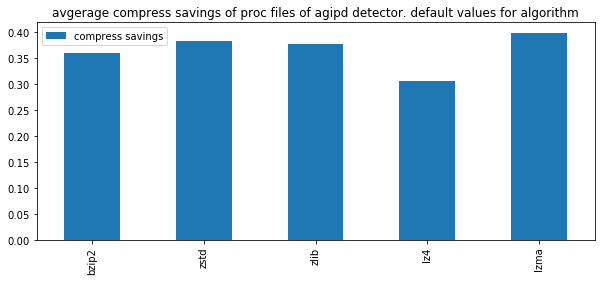

In [38]:
#space savings of proc file
bar_arr = ['bzip2', 'zstd', 'zlib', 'lz4' , 'lzma']
freq_arr_savings_compress_proc = np.array([spaceSavingsAverage(agipd_bz2_proc_compressed_dict), 
                     spaceSavingsAverage(agipd_zstd_proc_compressed_dict), 
                     spaceSavingsAverage(agipd_zlib_proc_compressed_dict), 
                     spaceSavingsAverage(agipd_lz4_proc_compressed_dict), 
                     spaceSavingsAverage(agipd_lzma_proc_compressed_dict)])

df = pd.DataFrame(np.c_[freq_arr_savings_compress_proc], index=bar_arr)

print(df)

ax = df.plot.bar(figsize=(10,4))
ax.legend(['compress savings'])
plt.title('avgerage compress savings of proc files of agipd detector. default values for algorithm')

plt.show()

### Compression Savings AGIPD Detector (Raw Files)

              0
bzip2  0.332911
zstd   0.214262
zlib   0.234922
lz4    0.004619
lzma   0.321620


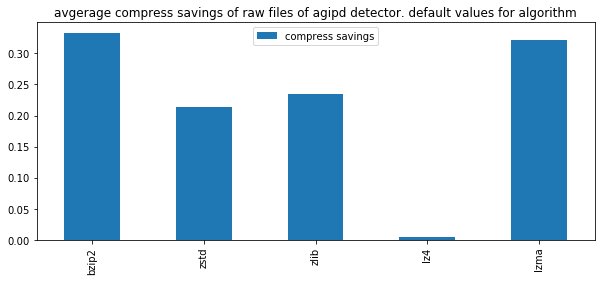

In [10]:
#space savings of raw file
bar_arr = ['bzip2', 'zstd', 'zlib', 'lz4' , 'lzma']
freq_arr_savings_compress_raw = np.array([spaceSavingsAverage(agipd_bz2_raw_compressed_dict), 
                     spaceSavingsAverage(agipd_zstd_raw_compressed_dict), 
                     spaceSavingsAverage(agipd_zlib_raw_compressed_dict), 
                     spaceSavingsAverage(agipd_lz4_raw_compressed_dict), 
                     spaceSavingsAverage(agipd_lzma_raw_compressed_dict)])

df = pd.DataFrame(np.c_[freq_arr_savings_compress_raw], index=bar_arr)

print(df)

ax = df.plot.bar(figsize=(10,4))
ax.legend(['compress savings'])
plt.title('avgerage compress savings of raw files of agipd detector. default values for algorithm')

plt.show()

### Compression time AGIPD Detector (Proc Files)

                 0
bzip2  1110.103332
zstd     19.365837
zlib    446.747473
lz4      10.327610
lzma   4024.272391


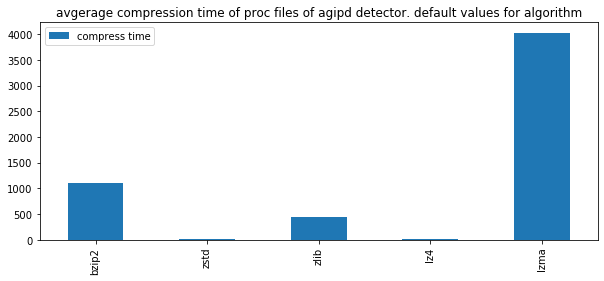

In [35]:
#space savings of proc file
bar_arr = ['bzip2', 'zstd', 'zlib', 'lz4' , 'lzma']
freq_arr_time_compress_proc = np.array([timeAverage(agipd_bz2_proc_compressed_dict, 'time_compression'), 
                     timeAverage(agipd_zstd_proc_compressed_dict, 'time_compression'), 
                     timeAverage(agipd_zlib_proc_compressed_dict, 'time_compression'), 
                     timeAverage(agipd_lz4_proc_compressed_dict, 'time_compression'), 
                     timeAverage(agipd_lzma_proc_compressed_dict, 'time_compression')])

df = pd.DataFrame(np.c_[freq_arr_time_compress_proc], index=bar_arr)

print(df)

ax = df.plot.bar(figsize=(10,4))
ax.legend(['compress time'])
plt.title('avgerage compression time of proc files of agipd detector. default values for algorithm')

plt.show()

### Decompression time AGIPD Detector (Proc Files)

                0
bzip2  606.670412
zstd    14.738191
zlib    59.818639
lz4     10.929551
lzma   567.600156


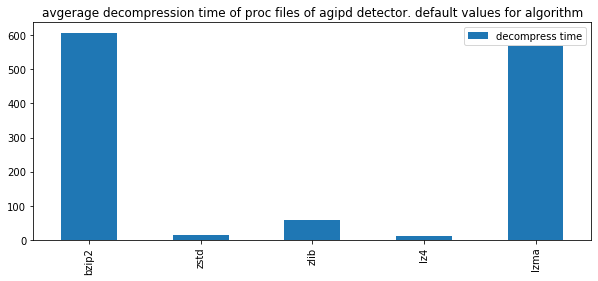

In [37]:
#space savings of proc file
bar_arr = ['bzip2', 'zstd', 'zlib', 'lz4' , 'lzma']
freq_arr_time_compress_proc = np.array([timeAverage(agipd_bz2_proc_compressed_dict, 'time_decompression'), 
                     timeAverage(agipd_zstd_proc_compressed_dict, 'time_decompression'), 
                     timeAverage(agipd_zlib_proc_compressed_dict, 'time_decompression'), 
                     timeAverage(agipd_lz4_proc_compressed_dict, 'time_decompression'), 
                     timeAverage(agipd_lzma_proc_compressed_dict, 'time_decompression')])

df = pd.DataFrame(np.c_[freq_arr_time_compress_proc], index=bar_arr)

print(df)

ax = df.plot.bar(figsize=(10,4))
ax.legend(['decompress time'])
plt.title('avgerage decompression time of proc files of agipd detector. default values for algorithm')

plt.show()